# Topic Modeling

## Imports de llibreries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import spacy
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
import warnings
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
import os
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


/home/arnauberenguer/eurecat_feina/dades-assemblea-clima/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Càrrega del dataset

In [2]:
df_proposals = pd.read_csv("../data/processed/processed_proposals.csv")

## Text de les propostes

Primer carreguem el dataset de stopwords en català perquè no es tinguin en compte a l'hora de fer topic modeling i després tokenitzem el text havent-lo lemmatitzat abans per passar les paraules a singular, masculí, etc... per evitar problemes.

In [3]:
nlp = spacy.load("ca_core_news_sm")

stop_words = set(nltk.corpus.stopwords.words('catalan'))

def clean_text(headline):
    # Tokenize the text
    doc = nlp(headline)
    
    # Lemmatize and filter tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.text.lower() not in stop_words and len(token.text) > 3]
    
    # Join the tokens back into a string
    cleaned_text = " ".join(tokens)
    return cleaned_text

df_proposals['body_preprocessed'] = df_proposals['body/ca'].apply(clean_text)
df_proposals.head()

,id,title/ca,body/ca,endorsements/total_count,comments,attachments,followers,published_at,is_amend,published_at_dies,body_preprocessed
0,87446,Participar Assemblea Ciutadana pel Clima de Ca...,"Buenos días, me gustaría participar en la asam...",4,0,0,2,2023-10-09 11:27:07+00:00,False,123.937350,Buenos días gustaríar participar asamblea ciud...
1,87447,Assemblea ciutadana pel clima de Catalunya,M'agradaria participar en aquesta assemblea pe...,1,1,0,3,2023-10-10 08:38:57+00:00,False,123.054132,agradar participar assemblea clima rebar carta...
2,87452,"Transició a producció, comerç i consum ecològi...","La producció, comerç i consum d'aliments no ec...",1,0,0,2,2023-10-13 10:32:35+00:00,False,119.975220,producció comerç consum aliment ecològic local...
3,87453,"L'aigua, el principal aliment.",La major part dels pous catalans ni són legals...,3,0,0,3,2023-10-13 10:40:31+00:00,False,119.969711,major part pou català legal monitoratge contin...
4,87454,Prohibir construccions no bioclimàtiques,La normativa no hauria de permetre cap constru...,3,0,0,3,2023-10-13 10:50:31+00:00,False,119.962766,normativa haver permetre construcció edificaci...


### Model LSA (Latent Semantic Analysis o TruncatedSVD)

Primer vectoritzem el text amb un TTIDF Vectorizer.

In [4]:
vect = TfidfVectorizer(max_features=59, stop_words=list(stop_words)) # Tocar max_features per adaptar el model
vect_text = vect.fit_transform(df_proposals['body_preprocessed'])

Després realitzem un GridSearch per trobar la millor combinació d'hiperparàmetres per aplicar al model i que obtingui millor performance.

In [5]:
param_grid = {
    'lsa__n_components': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 59],
    'lsa__n_iter': [5,10,15,20,25,30,35,40,45,50,55,60]
}

# Definim la manera en que calcula les scores amb la simple MSE (Mitjana de l'error quadràtic)
scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Use mean squared error as an example

pipeline = Pipeline([
    ('vect', TfidfVectorizer(max_features=59, stop_words=list(stop_words))),
    ('lsa', TruncatedSVD(random_state=42))
])

# Fem el grid search per trobar els millors paràmetres
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=0, scoring=scorer)
grid_search.fit(df_proposals['body_preprocessed'])

# Imprimim els millors paràmetres per introduir-los al model definitiu
print("Best Parameters:", grid_search.best_params_)

/home/arnauberenguer/eurecat_feina/dades-assemblea-clima/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arnauberenguer/eurecat_feina/dades-assemblea-clima/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/arnauberenguer/eurecat_feina/dades-assemblea-clima/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/arnauberenguer/eurecat_feina/dades

Best Parameters: {'lsa__n_components': 10, 'lsa__n_iter': 5}


In [6]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized',n_iter=5, random_state=42)
lsa_top = lsa_model.fit_transform(vect_text)


# Paraules més importants de cada tòpic
vocab = vect.get_feature_names_out()

In [7]:
def get_top_words_for_document(doc_index, lsa_model, vocab, num_top_words=7): # Modificar num_top_words per mostrar quantes top words considerem
    doc_topic_distribution = lsa_model.transform(vect_text[doc_index])
    
    top_topic_index = np.argmax(doc_topic_distribution)
    
    top_words_indices = lsa_model.components_[top_topic_index].argsort()[:-num_top_words-1:-1]
    top_words = [vocab[j] for j in top_words_indices]
    
    return top_words

df_proposals['top_topic_words_lsa'] = df_proposals.index.map(lambda x: get_top_words_for_document(x, lsa_model, vocab))


In [8]:
df_proposals.head(10)

,id,title/ca,body/ca,endorsements/total_count,comments,attachments,followers,published_at,is_amend,published_at_dies,body_preprocessed,top_topic_words_lsa
0,87446,Participar Assemblea Ciutadana pel Clima de Ca...,"Buenos días, me gustaría participar en la asam...",4,0,0,2,2023-10-09 11:27:07+00:00,False,123.937350,Buenos días gustaríar participar asamblea ciud...,"[participar, clima, agradar, assemblea, tema, ..."
1,87447,Assemblea ciutadana pel clima de Catalunya,M'agradaria participar en aquesta assemblea pe...,1,1,0,3,2023-10-10 08:38:57+00:00,False,123.054132,agradar participar assemblea clima rebar carta...,"[participar, clima, agradar, assemblea, tema, ..."
2,87452,"Transició a producció, comerç i consum ecològi...","La producció, comerç i consum d'aliments no ec...",1,0,0,2,2023-10-13 10:32:35+00:00,False,119.975220,producció comerç consum aliment ecològic local...,"[residu, alimentari, canvi, aliment, sostenibl..."
3,87453,"L'aigua, el principal aliment.",La major part dels pous catalans ni són legals...,3,0,0,3,2023-10-13 10:40:31+00:00,False,119.969711,major part pou català legal monitoratge contin...,"[aigua, participar, energia, transport, agrada..."
4,87454,Prohibir construccions no bioclimàtiques,La normativa no hauria de permetre cap constru...,3,0,0,3,2023-10-13 10:50:31+00:00,False,119.962766,normativa haver permetre construcció edificaci...,"[aigua, participar, energia, transport, agrada..."
5,87458,Projectes del futur,"Hola, sóc un jove graduat en enginyeria; M'agr...",1,0,0,1,2023-10-14 14:38:54+00:00,False,118.804167,Hola jove graduat enginyeria agradar participa...,"[aigua, participar, energia, transport, agrada..."
6,87460,Ordenació medioambiental. Tractament dels resi...,1.- Residus: Es podria instal.lar màquines de ...,5,0,0,2,2023-10-14 14:58:27+00:00,False,118.790590,Residus poder instal.lar màquina recollida lla...,"[aigua, participar, energia, transport, agrada..."
7,87461,Procés de selecció,"Referent al procés de selecció, no entenc perq...",3,3,0,1,2023-10-15 16:24:45+00:00,False,117.730660,referent procés selecció entendre envíen aleat...,"[participar, clima, agradar, assemblea, tema, ..."
8,87462,"Decreixement, Aigua i Sobirania alimentària ag...",Estem entrant en un caos climàtic terrible. Ai...,5,0,0,4,2023-10-15 19:02:35+00:00,False,117.621053,entrar caos climàtic terrible Aigua Sobirania ...,"[residu, alimentari, canvi, aliment, sostenibl..."
9,87464,Apropament entre generació i consum d'energia ...,Crec que caldria potenciar l'apropament entre ...,1,1,0,2,2023-10-15 20:58:48+00:00,False,117.540347,creure caldre potenciar apropament producció c...,"[aigua, participar, energia, transport, agrada..."


### LDA Model (Latent Dirichlet Allocation)

Primer realitzem un SearchGrid per comprovar quina és la millor combinació de hiperparàmetres per al model LDA.

In [9]:
param_grid = {
    'n_components': [10,15, 20,25, 30,35, 40,45, 50, 59],
    'learning_method': ['batch', 'online'],
    'learning_decay': [0.5, 0.7, 0.9],
    'max_iter': [10, 20, 30, 40, 50, 60]
}

# Inicialitzem el model base LDA
lda_model = LatentDirichletAllocation(random_state=42)

# Realitzem grid search per trobar la millor combinació de paràmetres pel model LDA
grid_search = GridSearchCV(lda_model, param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(vect_text)

# Imprimim la millor combinació de paràmetres per introduir-la al model definitiu
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_decay': 0.7, 'learning_method': 'online', 'max_iter': 60, 'n_components': 10}


In [10]:
# Creem el model LDA amb els paràmetres trobats amb anterioritat
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', learning_decay=0.7, random_state=42, max_iter=60)
lda_top = lda_model.fit_transform(vect_text)

def get_top_words_for_document_lda(doc_index, lda_model, vect, num_top_words=7):
    doc_topic_distribution = lda_model.transform(vect_text[doc_index])
    
    top_topic_index = np.argmax(doc_topic_distribution)
    
    top_words_indices = lda_model.components_[top_topic_index].argsort()[:-num_top_words-1:-1]
    top_words = [vocab[j] for j in top_words_indices]
    
    return top_words

df_proposals['top_topic_words_lda'] = df_proposals.index.map(lambda x: get_top_words_for_document_lda(x, lda_model, vocab))

In [11]:
df_proposals.head(10)

,id,title/ca,body/ca,endorsements/total_count,comments,attachments,followers,published_at,is_amend,published_at_dies,body_preprocessed,top_topic_words_lsa,top_topic_words_lda
0,87446,Participar Assemblea Ciutadana pel Clima de Ca...,"Buenos días, me gustaría participar en la asam...",4,0,0,2,2023-10-09 11:27:07+00:00,False,123.937350,Buenos días gustaríar participar asamblea ciud...,"[participar, clima, agradar, assemblea, tema, ...","[projecte, parar, tema, participar, consum, ac..."
1,87447,Assemblea ciutadana pel clima de Catalunya,M'agradaria participar en aquesta assemblea pe...,1,1,0,3,2023-10-10 08:38:57+00:00,False,123.054132,agradar participar assemblea clima rebar carta...,"[participar, clima, agradar, assemblea, tema, ...","[participar, agradar, assemblea, clima, gent, ..."
2,87452,"Transició a producció, comerç i consum ecològi...","La producció, comerç i consum d'aliments no ec...",1,0,0,2,2023-10-13 10:32:35+00:00,False,119.975220,producció comerç consum aliment ecològic local...,"[residu, alimentari, canvi, aliment, sostenibl...","[aliment, canvi, territori, pagès, sostenible,..."
3,87453,"L'aigua, el principal aliment.",La major part dels pous catalans ni són legals...,3,0,0,3,2023-10-13 10:40:31+00:00,False,119.969711,major part pou català legal monitoratge contin...,"[aigua, participar, energia, transport, agrada...","[residu, solar, caldre, ciutadà, crear, ex, ca..."
4,87454,Prohibir construccions no bioclimàtiques,La normativa no hauria de permetre cap constru...,3,0,0,3,2023-10-13 10:50:31+00:00,False,119.962766,normativa haver permetre construcció edificaci...,"[aigua, participar, energia, transport, agrada...","[aire, nou, espai, arbre, energètic, millorar,..."
5,87458,Projectes del futur,"Hola, sóc un jove graduat en enginyeria; M'agr...",1,0,0,1,2023-10-14 14:38:54+00:00,False,118.804167,Hola jove graduat enginyeria agradar participa...,"[aigua, participar, energia, transport, agrada...","[projecte, parar, tema, participar, consum, ac..."
6,87460,Ordenació medioambiental. Tractament dels resi...,1.- Residus: Es podria instal.lar màquines de ...,5,0,0,2,2023-10-14 14:58:27+00:00,False,118.790590,Residus poder instal.lar màquina recollida lla...,"[aigua, participar, energia, transport, agrada...","[aigua, instal, davant, solar, local, solució,..."
7,87461,Procés de selecció,"Referent al procés de selecció, no entenc perq...",3,3,0,1,2023-10-15 16:24:45+00:00,False,117.730660,referent procés selecció entendre envíen aleat...,"[participar, clima, agradar, assemblea, tema, ...","[participar, agradar, assemblea, clima, gent, ..."
8,87462,"Decreixement, Aigua i Sobirania alimentària ag...",Estem entrant en un caos climàtic terrible. Ai...,5,0,0,4,2023-10-15 19:02:35+00:00,False,117.621053,entrar caos climàtic terrible Aigua Sobirania ...,"[residu, alimentari, canvi, aliment, sostenibl...","[producció, aigua, sobirania, alimentari, ener..."
9,87464,Apropament entre generació i consum d'energia ...,Crec que caldria potenciar l'apropament entre ...,1,1,0,2,2023-10-15 20:58:48+00:00,False,117.540347,creure caldre potenciar apropament producció c...,"[aigua, participar, energia, transport, agrada...","[ciutat, transport, energia, elèctric, gran, t..."


## Comparativa dels models

Per poder comparar els dos models, farem servir la mètrica de la coherència, que mesura la interpretabilitat dels tòpics, quantificant com de semànticament similars són les paraules d'un tòpic són. A major coherència, millor performance del model. Finalment també farem servir la mesura de la perplexitat en el model LDA, que mesura com de bé el model és capaç de predir una mostra donada. Com més baixa sigui la perplexitat, millor resultats obté el model. Cal destacar que aquesta mètrica només es pot aplicar al model LDA i no l'LSA.

### LSA o TruncatedSVD

In [12]:
def calculate_lsa_coherence(lsa_model, vect, vocab, num_top_words=5):
    coherence_scores = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        # Agafem les num_top_words paraules del tòpic que estem tractant.
        top_words_indices = topic.argsort()[:-num_top_words-1:-1]
        top_words = [vocab[j] for j in top_words_indices]

        # Transformem les top words a l'espai TF-IDF
        top_words_tfidf = vect[:, top_words_indices]

        # Calculem la matriu de similaritat a través de la similaritat per cosinus de cada parella de paraules
        similarity_matrix = cosine_similarity(top_words_tfidf.T)

        # Excloem els valors diagonals i n'extraiem la mitjana de la resta de valors de la matriu.
        coherence_score = np.mean(similarity_matrix[np.triu_indices(len(top_words), k=1)])
        coherence_scores.append(coherence_score)
    
    # Calculem la coherència mitjana de tots els tòpics per tenir un score global
    average_coherence = np.mean(coherence_scores)
    return average_coherence

lsa_coherence_score = calculate_lsa_coherence(lsa_model, vect_text, vocab)
print("LSA Coherence Score:", lsa_coherence_score)


LSA Coherence Score: 0.19033012107247732


### LDA

In [13]:
def calculate_lda_coherence(lda_model, vect, vocab, num_top_words=5):
    coherence_scores = []
    for topic_idx, topic in enumerate(lda_model.components_):
        # Agafem les num_top_words paraules del tòpic que tractem
        top_words_indices = topic.argsort()[:-num_top_words-1:-1]
        top_words = [vocab[j] for j in top_words_indices]

        # Transformem les top words a l'espai TF-IDF
        top_words_tfidf = vect[:, top_words_indices]

        # Calculem la matriu de similaritat a través de la similaritat per cosinus de cada parella de paraules
        similarity_matrix = cosine_similarity(top_words_tfidf.T)

        # Excloem els valors diagonals i n'extraiem la mitjana de la resta de valors de la matriu.
        coherence_score = np.mean(similarity_matrix[np.triu_indices(len(top_words), k=1)])
        coherence_scores.append(coherence_score)

    # Calculem la coherència mitjana de tots els tòpics per tenir un score global
    average_coherence = np.mean(coherence_scores)
    return average_coherence

lda_coherence_score = calculate_lda_coherence(lda_model, vect_text, vocab)
print("LDA Coherence Score:", lda_coherence_score)


LDA Coherence Score: 0.21683089264120414


#### Perplexitat del model LDA

In [14]:
print("LDA Perplexity score: ", lda_model.perplexity(vect_text))

LDA Perplexity score:  715.4725356206814


### BERTopic
TODO: Extreure el BERTopicWrapper a una llibreria pròpia

In [15]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

class BERTopicWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=15, top_n_words=4, stop_words=None):
        self.n_clusters = n_clusters
        self.top_n_words = top_n_words
        self.stop_words = stop_words if stop_words is not None else []
        self.model = None
    
    def fit(self, X, y=None):
        vectorizer_model = CountVectorizer(stop_words=list(self.stop_words))
        cluster_model = KMeans(n_clusters=self.n_clusters)
        self.model = BERTopic(language="catalan", vectorizer_model=vectorizer_model, hdbscan_model=cluster_model, top_n_words=self.top_n_words)
        self.model.fit(X)
        return self

    def transform(self, X):
        return self.model.transform(X)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def get_params(self, deep=True):
        return {
            'n_clusters': self.n_clusters,
            'top_n_words': self.top_n_words,
            'stop_words': self.stop_words
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def get_topic_info(self):
        return self.model.get_topic_info()
    
    def get_document_info(self, documents):
        return self.model.get_document_info(documents)


def silhouette_scorer(estimator, X):
    topics, probs = estimator.transform(X)
    labels = estimator.hdbscan_model.labels_
    valid_points = labels != -1
    if np.sum(valid_points) > 1:
        score = silhouette_score(X[valid_points], labels[valid_points])
        return score
    else:
        return -1
    

parameter_grid = {
    'bert__hdbscan_model__n_clusters': [10, 11, 12, 13, 14, 15, 20, 25],
    'bert__top_n_words': [3,4,5]
}

initial_topic_model = BERTopicWrapper(stop_words=stop_words)

search = GridSearchCV(estimator=initial_topic_model, param_grid=parameter_grid, cv=2, scoring=silhouette_scorer, refit=True)
search.fit(df_proposals['body/ca'])

best_params = search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'bert__hdbscan_model__n_clusters': 10, 'bert__top_n_words': 3}


In [16]:
best_model = BERTopicWrapper(
    n_clusters=best_params['bert__hdbscan_model__n_clusters'],
    top_n_words=best_params['bert__top_n_words'],
    stop_words=stop_words
)
best_topics, best_probs, = best_model.fit_transform(df_proposals['body/ca'])

In [17]:
topic_list = best_model.model.get_document_info(df_proposals['body/ca'])['Top_n_words']
df_proposals['topics_bert'] = topic_list
df_proposals.head()

,id,title/ca,body/ca,endorsements/total_count,comments,attachments,followers,published_at,is_amend,published_at_dies,body_preprocessed,top_topic_words_lsa,top_topic_words_lda,topics_bert
0,87446,Participar Assemblea Ciutadana pel Clima de Ca...,"Buenos días, me gustaría participar en la asam...",4,0,0,2,2023-10-09 11:27:07+00:00,False,123.937350,Buenos días gustaríar participar asamblea ciud...,"[participar, clima, agradar, assemblea, tema, ...","[projecte, parar, tema, participar, consum, ac...",las - para - as
1,87447,Assemblea ciutadana pel clima de Catalunya,M'agradaria participar en aquesta assemblea pe...,1,1,0,3,2023-10-10 08:38:57+00:00,False,123.054132,agradar participar assemblea clima rebar carta...,"[participar, clima, agradar, assemblea, tema, ...","[participar, agradar, assemblea, clima, gent, ...",participar - magradaria - carta
2,87452,"Transició a producció, comerç i consum ecològi...","La producció, comerç i consum d'aliments no ec...",1,0,0,2,2023-10-13 10:32:35+00:00,False,119.975220,producció comerç consum aliment ecològic local...,"[residu, alimentari, canvi, aliment, sostenibl...","[aliment, canvi, territori, pagès, sostenible,...",dieta - productes - ms
3,87453,"L'aigua, el principal aliment.",La major part dels pous catalans ni són legals...,3,0,0,3,2023-10-13 10:40:31+00:00,False,119.969711,major part pou català legal monitoratge contin...,"[aigua, participar, energia, transport, agrada...","[residu, solar, caldre, ciutadà, crear, ex, ca...",haurien - wc - edificis
4,87454,Prohibir construccions no bioclimàtiques,La normativa no hauria de permetre cap constru...,3,0,0,3,2023-10-13 10:50:31+00:00,False,119.962766,normativa haver permetre construcció edificaci...,"[aigua, participar, energia, transport, agrada...","[aire, nou, espai, arbre, energètic, millorar,...",pagesos - aliments - balan


In [18]:
def calculate_bertopic_coherence(topic_model, docs):
    cleaned_docs = topic_model._preprocess_text(docs)
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topics = topic_model.get_topics()
    topics.pop(-1, None)
    topic_words = [
        [word for word, _ in topic_model.get_topic(topic) if word != ""] for topic in topics
    ]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

    coherence_model = CoherenceModel(topics=topic_words, 
                                texts=tokens, 
                                corpus=corpus,
                                dictionary=dictionary, 
                                coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(f"Coherència del model BERTopic: {coherence}")

calculate_bertopic_coherence(best_model.model, df_proposals['body/ca'])

Coherència del model BERTopic: 0.7473561720651893


#### Plots

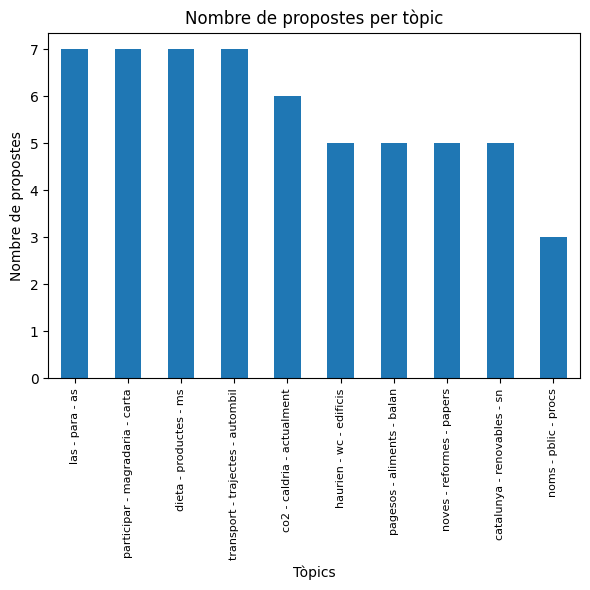

In [58]:
plt.figure(figsize=(6,6))
plt.rcParams.update({"font.size": 10})
df_proposals['topics_bert'].value_counts().plot(kind="bar")
plt.title("Nombre de propostes per tòpic")
plt.xlabel("Tòpics")
plt.ylabel("Nombre de propostes")
plt.xticks(fontsize=8)
plt.tight_layout()
plt.savefig("../plots/propostes_per_topic_catalunya.png")
plt.show()

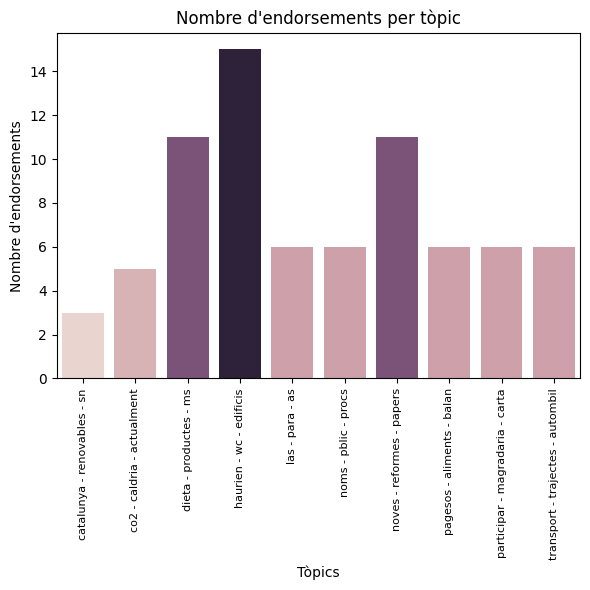

In [57]:
plt.figure(figsize=(6,6))
plt.title("Nombre d'endorsements per tòpic")
grouped = df_proposals.groupby("topics_bert")['endorsements/total_count'].sum().reset_index(name="count")
sns.barplot(data=grouped, x='topics_bert', y='count', hue='count', legend=False)
plt.xlabel("Tòpics")
plt.ylabel("Nombre d'endorsements")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("../plots/endorsements_per_topic_catalunya.png")
plt.show()

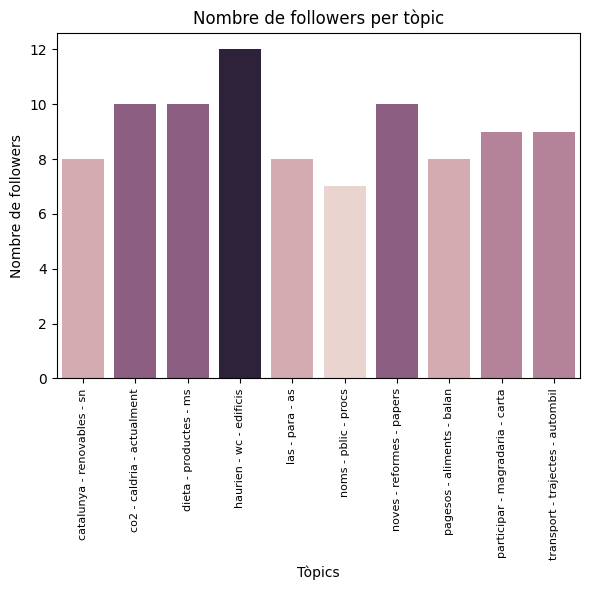

In [59]:
plt.figure(figsize=(6,6))
grouped = df_proposals.groupby("topics_bert")['followers'].sum().reset_index(name='count')
sns.barplot(data=grouped, x='topics_bert', y='count', hue='count', legend=False)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Tòpics")
plt.ylabel("Nombre de followers")
plt.title("Nombre de followers per tòpic")
plt.tight_layout()
plt.savefig("../plots/followers_per_topic_catalunya.png")
plt.show()

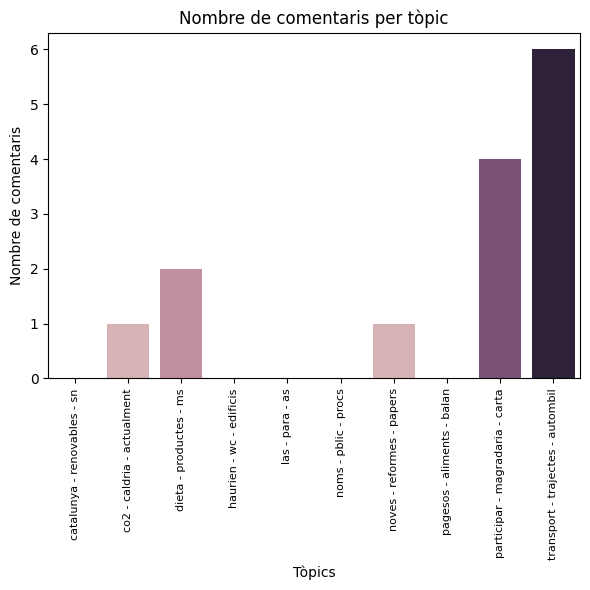

In [55]:
plt.figure(figsize=(6,6))
grouped = df_proposals.groupby("topics_bert")['comments'].sum().reset_index(name='count')
sns.barplot(data=grouped, x='topics_bert', y='count', legend=False, hue='count')
plt.title("Nombre de comentaris per tòpic")
plt.xlabel("Tòpics")
plt.ylabel("Nombre de comentaris")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("../plots/comentaris_per_topic_catalunya.png")
plt.show()

### Conclusions

Observem que el model LSA obté una puntuació de coherència de 0.20959362563222536, mentre que el model LDA obté 0.21683089264120414 i que el model BERTopic obté una coherència de 0.6766306970939527.

Així doncs, es veu que ambdós models bayesians obtenen una puntuació bastant similar, tot i que relativament baixa (com més proper a 1 millor coherència ténen). Això implica que si bé els tòpics generats pels dos models són relativament coherents, hi ha bastant marge de millora encara.

En contrast, el model BERTopic, aplicant la tècnica de clústering del KMeans, obté una puntuació molt millor de 0.6766306970939527 i per tant, resulta ser un model molt més coherent, també segurament degut a que es basa en xarxes neuronals i capes de transformers i no pas en models bayesians.

D'altra banda, pel que fa a la perplexitat del model LDA, que és de 715, indica que el model té una relativa bona performance quan es tracta de predir mostres que no ha vist encara, ja que com més baixa sigui la perplexitat, millor resultat obté. 

Val a dir però, que la perplexitat en si mateixa no aporta molta informació i que es necessitaria context comparant-ne el resultat amb el d'algun model similar.

En defintiva, doncs, el model amb el que obtenim millor resultats és amb diferència, el BERTopic, amb una millora de la coherència de 3.12x.